Wymagane są pliki 'train.csv' i 'store.csv' w tym samym katalogu.

In [ ]:
import pandas as pd
df1 = pd.read_csv('train.csv')
df2 = pd.read_csv('store.csv')

# Efektywnie left join (dla każdego dnia w train, dodajemy informacje o sklepie w którym jest)
df = pd.merge(df1, df2, left_on='Store', right_on='Store', how='left')

# Chcemy jeszcze wymieszać kolejność, bo oryginalne dane są rosnącą datą
df = df.sample(len(df))

/tmp/ipykernel_3027/2777014701.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv('train.csv')


In [2]:
# Główna rzecz jaką chcielibyśmy zmienić to jakoś skonwertować rzeczy, które nie są numeryczne
# Takie rzeczy to DayOfWeek, StateHoliday
# 1 podejściem będzie one-hot-encoding
df = pd.get_dummies(df, columns=['DayOfWeek','StateHoliday', 'StoreType', "Assortment"])

#Uzupełniamy jak nie ma dystansu do 100K (w pozostałych max to 75K)
df['CompetitionDistance'] = df['CompetitionDistance'].fillna(100000)



# Dodamy do tabelki
df['CompetitionOpenSinceYear'] = df['CompetitionOpenSinceYear'].fillna(2000)
df['CompetitionOpenSinceMonth'] = df['CompetitionOpenSinceMonth'].fillna(1)
df['CompetitionOpenSinceDay'] = 1

df_renamed = df.rename(columns={
    'CompetitionOpenSinceYear': 'year',
    'CompetitionOpenSinceMonth': 'month',
    'CompetitionOpenSinceDay': 'day'
})

df['CompetitionOpening'] = pd.to_datetime(df_renamed[['year', 'month', 'day']])
df['NewCompetition'] = df['CompetitionOpening']+ pd.DateOffset(months=6) >= df['Date']
df = pd.get_dummies(df, columns=['NewCompetition'])
# Usuwamy teraz już niepotrzebne nam kolumny - zamieniliśmy na datę
df.drop(['CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceDay'], axis=1, inplace=True)

Dzielimy dane na training, dev i test. Ma to na celu upewnić się, że nie 'zapamiętujemy' rozwiązań i model zadziała na nieznanych nam wcześniej danych podobnie dobrze.

In [4]:
training_len = (len(df) // 10) * 8
dev_len = len(df) // 10
test_len = len(df) - dev_len - training_len

df_train = df.iloc[:training_len]                       # 1 - 813759 train
df_dev = df.iloc[training_len:dev_len + training_len]   # 813760 - 915479 dev
df_test = df.iloc[dev_len + training_len:]              # 915480 - 1017208 test

Teraz zrobimy listę liniowych danych, żeby LinearRegression model miał szansę. Ponadto usuwam Customers, bo w oryginalnym wyzwaniu też tego nie było w 'test.csv'

In [5]:
# Nazwy kolumn do usunięcia z listy
to_remove = ['Store','Date', 'Sales', 'Customers', 'CompetitionOpening', 'Promo2SinceYear', 'Promo2SinceWeek', 'PromoInterval']
list_inputs = [x for x in list(df.columns) if x not in to_remove]

# Definiujemy
X_train, Y_train = df_train[list_inputs], df_train['Sales']
X_dev, Y_dev = df_dev[list_inputs], df_dev['Sales']
X_test, Y_test = df_test[list_inputs], df_test['Sales']
list_inputs

['Open',
 'Promo',
 'SchoolHoliday',
 'CompetitionDistance',
 'Promo2',
 'DayOfWeek_1',
 'DayOfWeek_2',
 'DayOfWeek_3',
 'DayOfWeek_4',
 'DayOfWeek_5',
 'DayOfWeek_6',
 'DayOfWeek_7',
 'StateHoliday_0',
 'StateHoliday_0',
 'StateHoliday_a',
 'StateHoliday_b',
 'StateHoliday_c',
 'StoreType_a',
 'StoreType_b',
 'StoreType_c',
 'StoreType_d',
 'Assortment_a',
 'Assortment_b',
 'Assortment_c',
 'NewCompetition_False',
 'NewCompetition_True']

Poniżej sprawdzamy jak dobrze radzi sobie LinearRegression, czyli do każdej kolumny przypisujemy jakąś wagę (w_i) tak by różnica między oczekiwanymi, a sumą a_i * w_i była możliwie mała

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
# Trenujemy model na X_train, Y_train
model = LinearRegression()
model.fit(X_train, Y_train)

# Aplikujemy model na X_test,dodatkowo maxujemy z zerem, bo nie ma negatywnych wartości
test_pred = model.predict(X_test)
test_pred = np.maximum(test_pred, 0)

# Wypisujemy kawałek
for i, j in zip(Y_test[:10], test_pred[:10]):
    print("actual: " + str(i) + " predicted: " + str(j))

# Liczymy średni squared error
rmse = mean_squared_error(Y_test, test_pred)
print(f"RMSE dla test: {rmse:.2f}")

Y_pred = model.predict(X_train)
Y_pred = np.maximum(Y_pred, 0)
rmse = mean_squared_error(Y_train, Y_pred)
print(f"RMSE dla train: {rmse:.2f}")

actual: 4162 predicted: 6450.899505027893
actual: 6879 predicted: 6030.892234503759
actual: 5608 predicted: 5266.224463039146
actual: 4652 predicted: 5614.131240983192
actual: 5565 predicted: 6261.103923480861
actual: 3907 predicted: 5999.352568406835
actual: 4640 predicted: 6408.187064367092
actual: 13738 predicted: 9103.063028857254
actual: 0 predicted: 556.7976360164672
actual: 4614 predicted: 8165.628997583191
RMSE dla test: 6288370.37
RMSE dla train: 6265760.22


In [7]:
# Teraz spróbbujemy czy przypadkiem jesteśmy w stanie przebić ten wynik przy pomocy sieci neuronowej z ukrytym layerem
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
g = torch.Generator().manual_seed(2147483647) # for reproducibility

In [8]:
# Funkcja robiąca 2 tensory z dataframów
def build_dataset(df1, df2):  
    X, Y= [],  []
    X = df1.values
    Y = df2.values
    X = torch.tensor(X, dtype=float)
    Y = torch.tensor(Y, dtype=float)
    return X, Y

maks = max(X_train['CompetitionDistance'])
X_train['CompetitionDistance'] = X_train['CompetitionDistance'] / maks
X_test['CompetitionDistance'] = X_test['CompetitionDistance'] / maks

Xtr, Ytr = build_dataset(X_train, Y_train)
Xte, Yte = build_dataset(X_test, Y_test)

/tmp/ipykernel_3027/2571476003.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['CompetitionDistance'] = X_train['CompetitionDistance'] / maks
/tmp/ipykernel_3027/2571476003.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['CompetitionDistance'] = X_test['CompetitionDistance'] / maks


In [ ]:
import torch.nn.init as init
n_hidden = 256 # ile jest neuronów w hidden layer
g = torch.Generator().manual_seed(2147483647) # f
block_size = Xtr.shape[1]  # input size (number of features)


# Create tensors with gradients enabled
W1 = torch.empty((block_size, n_hidden), requires_grad=True)  # (input_size, hidden_size)
b1 = torch.empty(n_hidden, requires_grad=True)  # (hidden_size,)
W2 = torch.empty((n_hidden, 1), requires_grad=True)  # (hidden_size, output_size)
b2 = torch.empty(1, requires_grad=True)  # (output_size,)

# Inicjalizujemy macierz
init.xavier_normal_(W1)  
init.zeros_(b1)  
init.xavier_normal_(W2)
init.zeros_(b2)

parameters = [W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True


7681


W komórce poniżej będziemy trenowali przez max_steps, za każdym razem losujemy batch_size i na podstawie tego zmieniamy parametry macierzy.

In [ ]:
max_steps = 250000
print_interval = 5000
batch_size = 256

# Tablica do robienia wykresu później
lossi = []

for i in range(max_steps):
  
  # Tworzymy batch
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]
  Xb = Xb.to(torch.float)
  Yb = Yb.float()
  Yb = Yb.view(-1,1)

  # Liczymy loss
  hpreact = Xb @ W1 + b1 
  h = torch.tanh(hpreact) # aplikujemy tanh
  res = h @ W2 + b2 
  res = res.float()
  loss = F.mse_loss(res, Yb, reduction = 'mean')

  # Obliczenie jak gradient wpływa na cokolwiek
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # Updatujemy parametry
  # Za duże parametry powodują, że może się pojawiać nan
  lr = 0.0005 if i < max_steps / 2 else 0.0001
  for p in parameters:
    p.data += -lr * p.grad

  # 
  lossi.append(loss.item())
  if i % print_interval == 0:
    print(str(i) + ": " +str(loss.item()))

0: 48182736.0
1000: 8202480.0
2000: 6737110.5
3000: 6843114.5
4000: 4880212.5
5000: 5147230.0
6000: 5862427.5
7000: 5234383.5
8000: 4529166.5
9000: 5570285.5
10000: 8873271.0
11000: 5957195.0
12000: 8529313.0
13000: 7566853.0
14000: 5000805.5
15000: 4626560.0
16000: 4812877.0
17000: 5966339.0
18000: 3568455.75
19000: 5504687.5
20000: 8345292.0
21000: 6740272.0
22000: 5695942.0
23000: 8121194.5
24000: 4849581.5
25000: 6081071.0
26000: 4053619.0
27000: 5725919.0
28000: 4522984.0
29000: 7201524.5
30000: 6247569.5
31000: 6885536.0
32000: 5997257.0
33000: 7517244.5
34000: 4442122.0
35000: 6758719.0
36000: 7067961.0
37000: 5971932.0
38000: 5477555.5
39000: 5115774.5
40000: 5121627.5
41000: 5233043.5
42000: 6023403.0
43000: 6139742.0
44000: 7457613.0
45000: 7283469.0
46000: 5268797.5
47000: 6530182.5
48000: 6174572.0
49000: 4881387.5
50000: 7476601.5
51000: 5502225.5
52000: 8338960.0
53000: 5442092.0
54000: 4893413.5
55000: 4874908.0
56000: 7040607.5
57000: 7711868.0
58000: 5526802.0
59000: 4

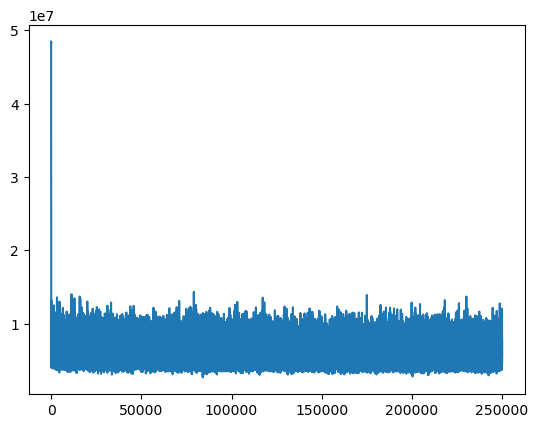

In [ ]:
#Rysuje wykres
plt.plot(lossi)

In [22]:
@torch.no_grad()
def oblicz_strate(X, Y):
    sum = 0
    for Xb,Yb in zip(X,Y):
        Xb = Xb.to(torch.float)
        hpreact = Xb @ W1 + b1 
        h = torch.tanh(hpreact)
        res = h @ W2 + b2
        sum += (res - Yb) ** 2
    return sum / len(X)
oblicz_strate(Xtr, Ytr)

tensor([5983371.])

In [23]:
oblicz_strate(Xte, Yte)

tensor([6010418.5000])

Finalne rezultaty na test secie to: <br>
6288370.37 dla RMSE <br>
6010418.50 dla sieci neuronowej